### This notebook will demonstrate 3 results.
1. Rotate the 2D slice image with Bessel function, stack the images back into a volume and compute the cost functions.
2. Translate the volume with a wrap around behavior to preserve energy inside of the volume, and compute cost functions with and without Halton sampling.
3. Maximum Likelihood Estimates of transformed images.

### Set up

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import math
import time
import numpy as np
import scipy
from scipy import ndimage
import ghalton
from scipy.interpolate import interp1d

In [21]:
'''
Helper function that cleans up list_directory
removes hidden files
'''
def clean(lis):
    try:
         
        lis.remove('.DS_Store')
    except:
        lis = lis
    return lis

'''
Helper function that retrieves all data files
cleans up the directory to leave only .dat files
'''
def get_files(lis):
    try:
        for i in list(lis):
            if('.dat' not in i):
                lis.remove(i)
    except:
        lis = lis
    return lis

###Function Definitions

In [22]:
# Bessel Rotation
def to_radian(theta):
    return theta*np.pi/180.
def bessel_rotate(image, theta):
    t0 = time.time()
    Ib = np.zeros(image.shape)
    theta = to_radian(theta)
    
    s = (image.shape[0]-1)/2.

    x = np.linspace(-s, s, image.shape[1])
    y = np.linspace(-s, s, image.shape[0])
    
    xx, yy = np.meshgrid(x,y)
    
    rM = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

    for i in np.arange(-s,s+1):
        for j in np.arange(-s,s+1):
            x = np.dot(rM, np.array([i,j]))

            if(np.sum(abs(x)>s)):
                Ib[i+s,j+s]=0
                
            else:
                R = np.sqrt((xx-x[1])**2 + (yy-x[0])**2)
                mask = (R == 0)
                Bess = np.zeros(R.shape)
                Bess[~mask] = scipy.special.j1(np.pi*R[~mask])/(np.pi*R[~mask])
                Bess[mask] = 0.5
                Ib[i+s,j+s] = (np.sum(image*Bess))*np.pi/2
    t1 = time.time()
    return Ib

In [23]:
# Trilinear Interpolation
def trilinear_interp(volume, x, y, z):
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    
    # find the closest grid of the target points
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1
    z0 = np.floor(z).astype(int)
    z1 = z0 + 1
    
    # Clip
    x0 = x0.clip(0, volume.shape[0]-1)
    x1 = x1.clip(0, volume.shape[0]-1)
    y0 = y0.clip(0, volume.shape[1]-1)
    y1 = y1.clip(0, volume.shape[1]-1)
    z0 = z0.clip(0, volume.shape[2]-1)
    z1 = z1.clip(0, volume.shape[2]-1)    

    # define some coefficients
    xd = x-x0
    yd = y-y0
    zd = z-z0
    
    # set up for the bilinear interpolation
    C00 = volume[y0,x0,z0]*(1-xd) + volume[y0,x1,z0]*xd
    C10 = volume[y1,x0,z0]*(1-xd) + volume[y1,x1,z0]*xd
    
    C01 = volume[y0,x0,z1]*(1-xd) + volume[y0,x1,z1]*xd
    C11 = volume[y1,x0,z1]*(1-xd) + volume[y1,x1,z1]*xd
    
    C0 = C00*(1-yd) + C10*yd
    C1 = C01*(1-yd) + C11*yd
    
    C = C0*(1-zd) + C1*zd
    return C

**Cost Functions**

In [24]:
def cf_ssd(J, I):
    return np.sum((J-I)**2)
def cf_L2(J, I):
    return np.linalg.norm(J-I)
def cf_L1(J, I):
    L1 = np.reshape((J-I), [1,-1])
    return np.max(L1)

In [25]:
def rot_cost_func(vol1, vol2, thetas, cf, arg, ax, interpolation = 'bilinear',mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    tmp = vol1.copy()
    cost_func = np.zeros(len(thetas))
    for idx, t in enumerate(thetas):
        new_vol2 = np.ones(vol2.shape)
        for i in xrange(32):
            if(mask):
                tmp[i,:,:] = circle_mask(tmp[i,:,:])
            sub = vol2[i,:,:]
            if(interpolation == 'bessel'):
                rot = bessel_rotate(sub, t)
            else:
                rot = imrotate(sub, t, interpolation, mask)
            new_vol2[i,:,:] = rot
        cost_func[idx] = cf(new_vol2,tmp)
    angMin = thetas[np.argmin(cost_func)]
    ax.plot(thetas,cost_func,label='Min angle = %s' % (angMin))
    ax.set_title('%s Cost function with %s interpolation' % (arg,interpolation), fontsize=14)
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Cost function')
    ax.legend(loc=4)

In [26]:
def translation(volume, t):
    return scipy.ndimage.interpolation.shift(volume, t, order=1, mode='wrap')

In [45]:
def vol_cost_func_t(vol1, vol2, t, cf, arg, ax):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    t: list of translation to try
    cf: cost function
    arg: string for plot titles
    '''
    cost_func = np.zeros(len(t))
    for idx, th in enumerate(t):
        new_vol2 = translation(vol2,th)
        cost_func[idx] = cf(new_vol2,vol1)
    tMin = t[np.argmin(cost_func)]
    t = np.array(t)
    ax.plot((t*8.)[:,2],cost_func,label='Min translation = %s' % (tMin[2]*8.))
    ax.set_title('%s Cost function with trilinear interpolation' % (arg), fontsize=14)
    ax.set_xlabel('Translation (mm)')
    ax.set_ylabel('Cost function')
    ax.legend(loc=1)

In [51]:
def halton_cost_func_t(N, vol1, vol2, t, arg, mask=False):
    '''
    N: Number of Halton Sampling Points
    vol1: original image
    vol2: volume to be rotated
    theta: rotation by degrees
    t: list of translations to try
    arg: string for plot titles
    '''
    cost_func = np.zeros(len(t))
    t0 = time.time()
    # generate Halton Sequence in the 32*32*32 grid
    sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
    sequencer.reset()
    points = sequencer.get(N)
    pts = np.array(points)
    x1 = 31 * pts[:,0]
    y1 = 31 * pts[:,1]
    z1 = 31 * pts[:,2]

    for idx, th in enumerate(t):
        new_vol2 = translation(vol2, th)
        v2 = trilinear_interp(new_vol2, x1, y1, z1)
        v1 = trilinear_interp(vol1, x1, y1, z1)
        cost_func[idx] = cf_ssd(v2,v1)
    t1 = time.time()
    print 'Time for %s halton samples is %s seconds' % (N,t1-t0) 

    tMin = t[np.argmin(cost_func)]
    t = np.array(t)
    plt.plot((t*8.)[:,2],cost_func,label='Min translation = %s' % (tMin[2]*8.))
    plt.title('%s Cost function with trilinear interpolation' % (arg), fontsize=14)
    plt.xlabel('Translation (mm)')
    plt.ylabel('Cost function')
    plt.legend(loc=1)
    plt.show()

In [59]:
def to_radian(theta):
    '''
    Convert theta from degrees to radians
    '''
    return theta*np.pi/180.


def Hamilton_product(a1, b1, c1, d1, a2, b2, c2, d2):
    a = a1*a2-b1*b2-c1*c2-d1*d2
    i = a1*b2+b1*a2+c1*d2-d1*c2
    j = a1*c2-b1*d2+c1*a2+d1*b2
    k = a1*d2+b1*c2-c1*b2+d1*a2
    return a, i, j, k

def rotate_coords_quaternion(theta, ui, uj, uk, t, x, y, z):
    """
    Return the position of rotated point about quaternion u by theta degrees
    """
    ox = oy = oz = 15.5
    x, y, z = np.asarray(x) - ox, np.asarray(y) - oy, np.asarray(z) - oz
    
    # convert degrees to radians
    theta = to_radian(theta)
    qr = np.cos(theta/2.)
    s = np.sin(theta/2.)
    
    # coefficients for q and q^-1
    a1 = qr
    b1 = ui*s
    c1 = uj*s
    d1 = uk*s

    # calculate q*p*q^-1
    qp_a1, qp_b1, qp_c1, qp_d1 = Hamilton_product(a1,b1,c1,d1,0,x,y,z)
    
    # calculate final coordinates
    a, b, c, d = Hamilton_product(qp_a1, qp_b1, qp_c1, qp_d1,a1,-b1,-c1,-d1)
    
    return b + t[0] + ox, c + t[1] + oy, d + t[1] + oz

def volrotate_quaternion(volume, theta, ui, uj, uk,  t, mask=False):
    """
    Rotate a given volume by theta degrees about the unit quarternion u
    """
    # find center of the volume
    ox = volume.shape[1]/2.-0.5
    oy = volume.shape[0]/2.-0.5
    oz = volume.shape[2]/2.-0.5
    
    x = np.linspace(0, volume.shape[1]-1, volume.shape[1]).astype(int)
    y = np.linspace(0, volume.shape[0]-1, volume.shape[0]).astype(int)
    z = np.linspace(0, volume.shape[2]-1, volume.shape[2]).astype(int)
    xx, yy, zz = np.meshgrid(x, y, z)
    
    dest_x, dest_y, dest_z = rotate_coords_quaternion(theta, ui, uj, uk, t, xx, yy, zz)
    
    dest = trilinear_interp(volume, dest_x, dest_y, dest_z)
    
    if(mask):
        dest = sphere_mask(dest)
    return dest

In [95]:
def Maximum_Likelihood(vol1, vol2, thetas, t, cf, arg, ax, interpolation='trilinear',rotate = None, mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    prob = np.zeros(len(thetas))
    for idx, th in enumerate(thetas):
        if(rotate == 'q'):
            new_vol2 = volrotate_quaternion(vol2, th, 0, 1, 0, t)
        else:
            new_vol2 = volrotate(vol2, 0, th, 0, t, interpolation)
        prob[idx] = np.sum(scipy.stats.norm.logpdf((new_vol2-vol1).ravel(),loc = 0,scale=0.5))
    pMin = thetas[np.argmax(prob)]
    ax.plot(thetas, prob, label='Max prob occurs at = %s' % (pMin))
    ax.set_title('%s Maximum Likelihood with trilinear interpolation\n' % (arg), fontsize=14)
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Log Likelihood')
    ax.legend(fontsize=12)

# 1. Bessel Rotation

Read in Test Data Set 1: One Pineapple with 5 degrees rotation. Select two volumes for testing and visulize them.

In [29]:
path = '/Users/zyzdiana/Dropbox/Spring2015/AC297r/Pineapple_images/'
files = get_files(os.listdir(path))

# Choose two volume and slice them to for testing.
vol1 = np.array(np.memmap(path+files[0], dtype=np.float32, mode='c', shape=(32,32,32)))
vol2 = np.array(np.memmap(path+files[5], dtype=np.float32, mode='c', shape=(32,32,32)))

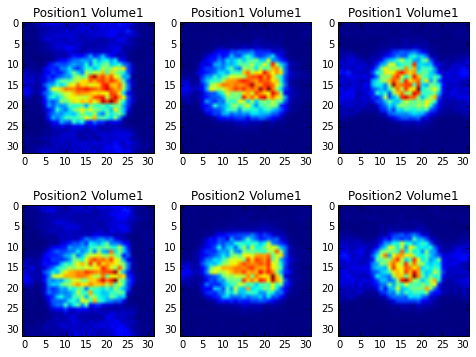

In [9]:
# Visulize the selected volumes
fig, ax = plt.subplots(2,3)
fig.set_figwidth(8)
fig.set_figheight(6)
[ax[0][i].imshow(vol1.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Position1 Volume%s' % (1)) for i in xrange(3)]
[ax[1][i].imshow(vol2.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Position2 Volume%s' % (1)) for i in xrange(3)]
plt.show()
plt.close(fig)

With the Bessel function, the discontinuity at zero in the SSD cost function was removed, and the curve is nice and smooth within the range [-5,10] degrees.

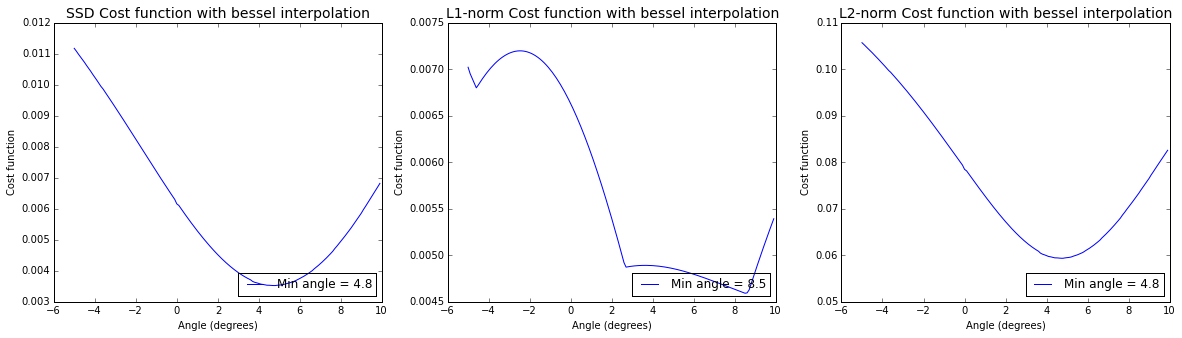

In [17]:
# Cost function from Bessel Rotation
thetas=np.arange(-5,10,0.1)
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0], 'bessel')
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1], 'bessel')
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2], 'bessel')
plt.show()
plt.close(fig)

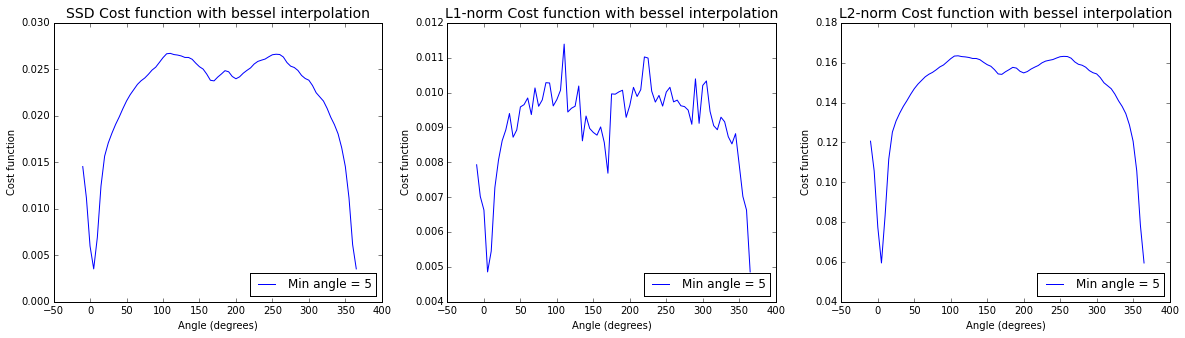

In [99]:
# Cost function from Bessel Rotation on a wider range
thetas=np.arange(-10,370,5)
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
rot_cost_func(vol1, vol2, thetas, cf_ssd, 'SSD',ax[0], 'bessel')
rot_cost_func(vol1, vol2, thetas, cf_L1, 'L1-norm',ax[1], 'bessel')
rot_cost_func(vol1, vol2, thetas, cf_L2, 'L2-norm',ax[2], 'bessel')
plt.show()
plt.close(fig)

# 1. Translation Cost Function with Halton Sampling
Read in Test Data Set 2: One Pineapple with 10mm translation. Select two volumes for testing and visulize them.

In [30]:
path1 = '/Users/zyzdiana/Dropbox/vNav_Test_Data/'
files1 = get_files(os.listdir(path1))
pos1 = files1[:(len(files1)/2)]
pos2 = files1[(len(files1)/2):]

vol2 = np.memmap(path1+pos1[5], dtype=np.float32, shape=(32,32,32))
vol2 = np.array(vol2)
vol3 = np.memmap(path1+pos1[10], dtype=np.float32, shape=(32,32,32))
vol3 = np.array(vol3)

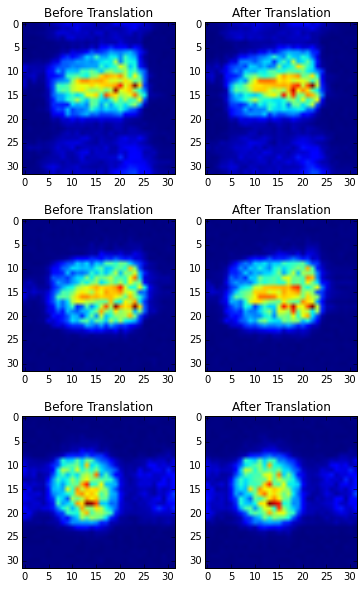

In [36]:
fig, ax = plt.subplots(3,2)
fig.set_figwidth(6)
fig.set_figheight(10)
[ax[i][0].imshow(vol2.max(axis=i),cmap='jet') for i in xrange(3)]
[ax[i][0].set_title('Before Translation') for i in xrange(3)]
[ax[i][1].imshow(vol3.max(axis=i),cmap='jet') for i in xrange(3)]
[ax[i][1].set_title('After Translation') for i in xrange(3)]
plt.show()
plt.close(fig)

###Discrete SSD

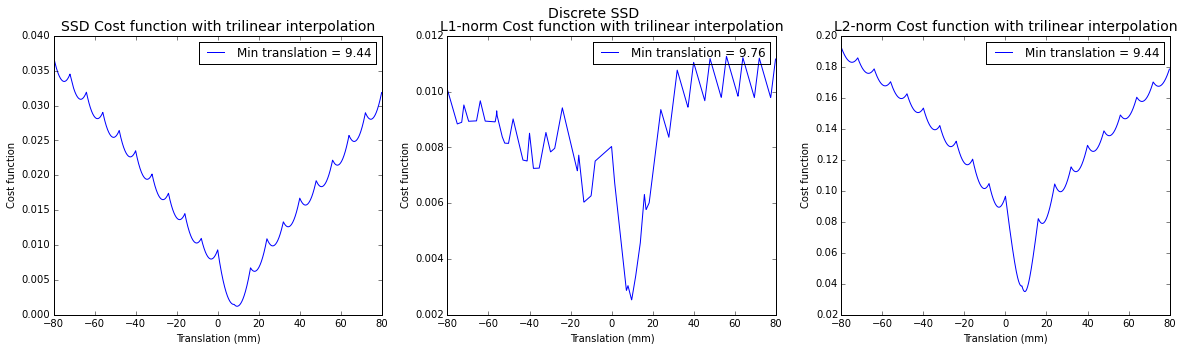

In [52]:
# Translation
t = []
for i in np.arange(-10,10,0.01):
    t.append([0,0,i])   
# Discrete Sum Cost Function
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Discrete SSD", fontsize=14)
vol_cost_func_t(vol2, vol3, t, cf_ssd, 'SSD',ax[0])
vol_cost_func_t(vol2, vol3, t, cf_L1, 'L1-norm',ax[1])
vol_cost_func_t(vol2, vol3, t, cf_L2, 'L2-norm',ax[2])
plt.show()
plt.close(fig)

###Integral SSD with Halton Sampling

Time for 100 halton samples is 5.48839783669 seconds


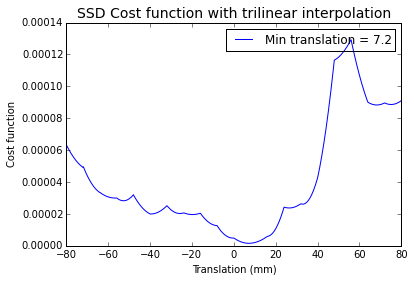

Time for 500 halton samples is 5.58524107933 seconds


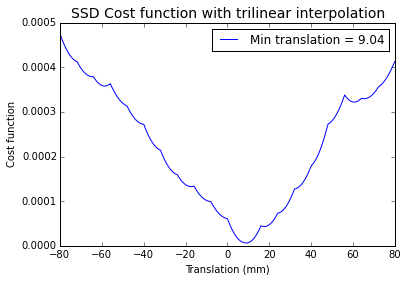

Time for 1000 halton samples is 5.52896690369 seconds


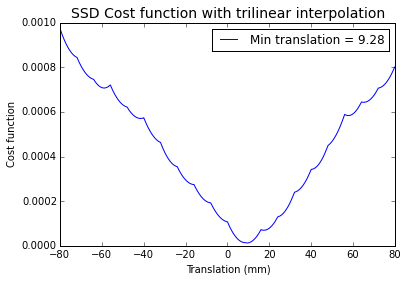

Time for 10000 halton samples is 10.0992789268 seconds


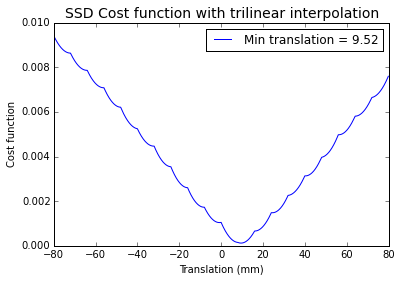

Time for 50000 halton samples is 36.9160602093 seconds


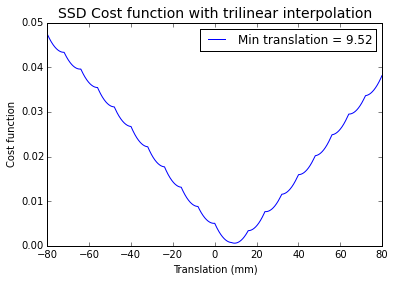

In [58]:
# Integral Cost function with Halton Sampling
halton_cost_func_t(100, vol2, vol3, t, 'SSD')
halton_cost_func_t(500, vol2, vol3, t, 'SSD')
halton_cost_func_t(1000, vol2, vol3, t, 'SSD')
halton_cost_func_t(10000, vol2, vol3, t, 'SSD')
halton_cost_func_t(50000, vol2, vol3, t, 'SSD')

Using Halton Sampling to evaluate the SSD cost function did smooth out the cost functiona as well as increasing the precision of the estimate.

# 3. Maximum Likelihood Estimates

Instead of using cost function, I tried using maximum likelihood methods to estimate the rotation. I'm still working on a rigorous proof of the model, but as of right  now, I will demonstrate the result from the data.(Here we are using the two volumes from part 1 with 5 degrees rotation.)

Let's denote the image without movement as `im1` and the image after movement as `im2`. If the `im2` has been rotated back to the original position perfectly, then $$im2 = im1 + \lambda\epsilon$$, where $\epsilon$ is the noise of the image, and $\lambda$ is a scaling constant which we know is normally distributed. We will now compute the difference $\frac{im2-im1}{\lambda}$ and assume it also follows a normal distribution and then do maximum likelihood estimation on the difference.

In [61]:
vol1 = np.memmap(path+files[0], dtype=np.float32, mode='c', shape=(32,32,32))
vol1 = np.array(vol1)
vol2 = np.memmap(path+files[5], dtype=np.float32, mode='c', shape=(32,32,32))
vol2 = np.array(vol2)

Below is a distribution plot of the difference between `im1` and rotated `im2`. We can see that they all have according to a $N(0,0.5^2)$ distribution

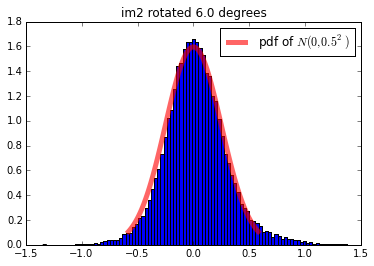

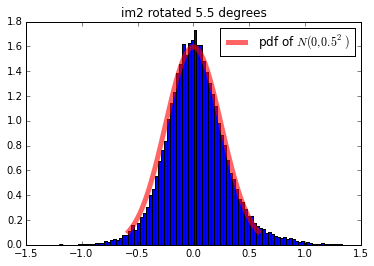

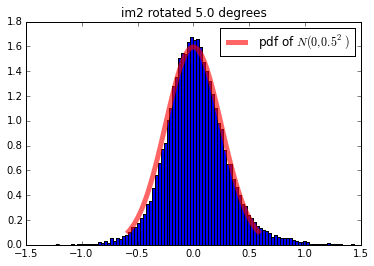

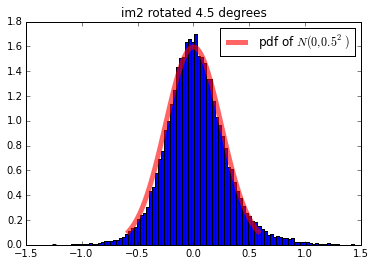

In [73]:
from scipy.stats import norm
thetas=np.arange(-6,-4,0.5)
t = np.zeros([3,])
sig = 0.25
x = np.linspace(norm.ppf(0.01, 0, sig), norm.ppf(0.99, 0, sig), 100)
y = norm.pdf(x, 0, sig)
for th in thetas:
    new_vol2 = volrotate_quaternion(vol2, th, 0, 1, 0, t)
    data = (new_vol2-vol1).ravel()
    plt.hist(2*data/((new_vol2+vol1).ravel()), bins=100, normed=True)
    plt.plot(x, y,'r-', lw=5, alpha=0.6, label = 'pdf of $N(0,0.5^2)$')
    plt.title('im2 rotated %s degrees' % -th)
    plt.legend()
    plt.show()

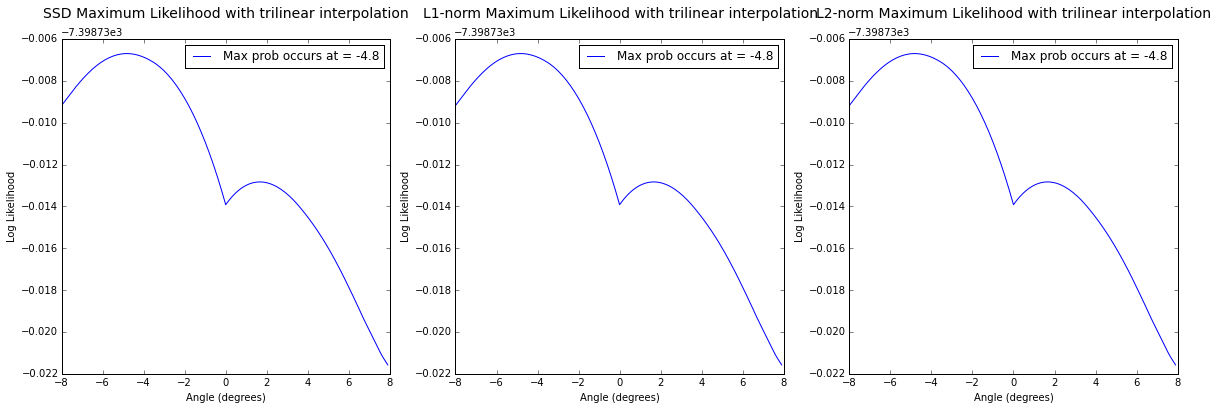

In [96]:
# Discrete Sum Cost Function with rotation matrix
thetas=np.arange(-8,8,0.1)
t = np.zeros([3,])
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(6)
Maximum_Likelihood(vol1, vol2, thetas, t, cf_ssd, 'SSD',ax[0], rotate='q')
Maximum_Likelihood(vol1, vol2, thetas, t, cf_L1, 'L1-norm',ax[1], rotate='q')
Maximum_Likelihood(vol1, vol2, thetas, t, cf_L2, 'L2-norm',ax[2], rotate='q')
plt.show()
plt.close(fig)